<a href="https://colab.research.google.com/github/OlamideIdowu/Lami-Clustering/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd

In [75]:
df = pd.read_csv("cus_seg.csv", delimiter='\t')

DATA CLEANING AND PROCESSING

In [76]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the output above, there are missing values in the income column, there are also categorical columns that need to be encoded. The Dt_customer column will be converted to datetime.

In [78]:
from sklearn.impute import SimpleImputer
import numpy as np

In [79]:
imputer = SimpleImputer(strategy = 'mean')

In [80]:
df['Income'] = imputer.fit_transform(df[['Income']])

In [81]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

In [82]:
from sklearn.preprocessing import LabelEncoder

In [83]:
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [84]:
columns = ["Education", "Marital_Status", "Dt_Customer"]
for col in columns:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

FEATURE ENGINEERING

In [85]:
#Extracting the age of each customer
current_date = pd.to_datetime('today')
df["Age"] = current_date.year - df["Year_Birth"]

In [86]:
#Calculating the amount spent by each customer
df["Amount_Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

In [87]:
to_drop = ['Year_Birth', 'ID']
df = df.drop(columns = to_drop)

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)

**DIMENSIONALITY REDUCTION WITH PCA**      
This is done to reduce the number of features and romve redundant or similar features.

In [89]:
from sklearn.decomposition import PCA

In [90]:
pca = PCA(n_components = 5)
pca.fit(scaled_df)

PCA(n_components=5)

In [91]:
final_df = pd.DataFrame(pca.transform(scaled_df), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [92]:
final_df_km = final_df.copy()

CLUSTERING WITH HIERARCHIAL CLUSTERING



In [93]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
from yellowbrick.cluster import KElbowVisualizer

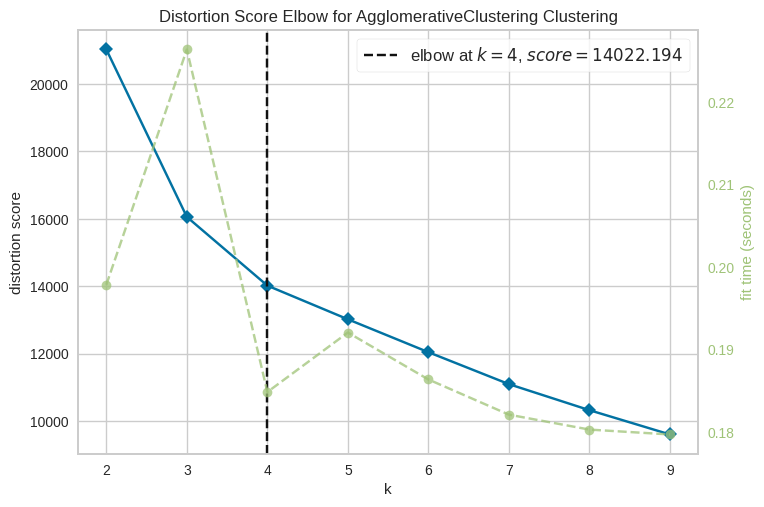

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [98]:
elbow = KElbowVisualizer(AgglomerativeClustering(), k=(2,10))
elbow.fit(final_df)
elbow.show()

In [104]:
clustering = AgglomerativeClustering(n_clusters = 4)
clustering.fit(final_df)
final_df["cluster"] = clustering.labels_

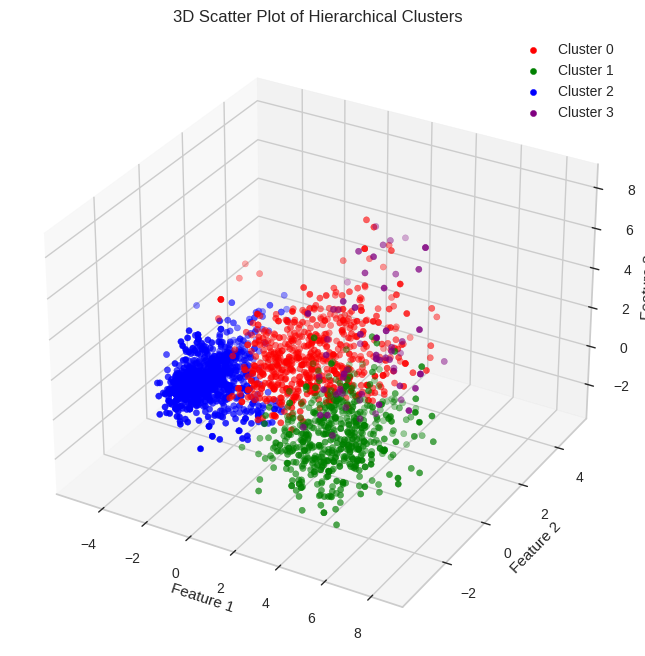

In [106]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'purple']
for cluster in range(4):
    cluster_data = final_df[final_df['cluster'] == cluster]
    # Replace 'feature1', 'feature2', 'feature3' with actual column names from your DataFrame
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Hierarchical Clusters')
ax.legend()
plt.show()

CLUSTERING WITH KMEANS

In [107]:
from sklearn.cluster import KMeans

In [108]:
optimal_k = elbow.elbow_value_
kmeans = KMeans(n_clusters = optimal_k)
kmeans.fit(final_df_km)
final_df_km["cluster"] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


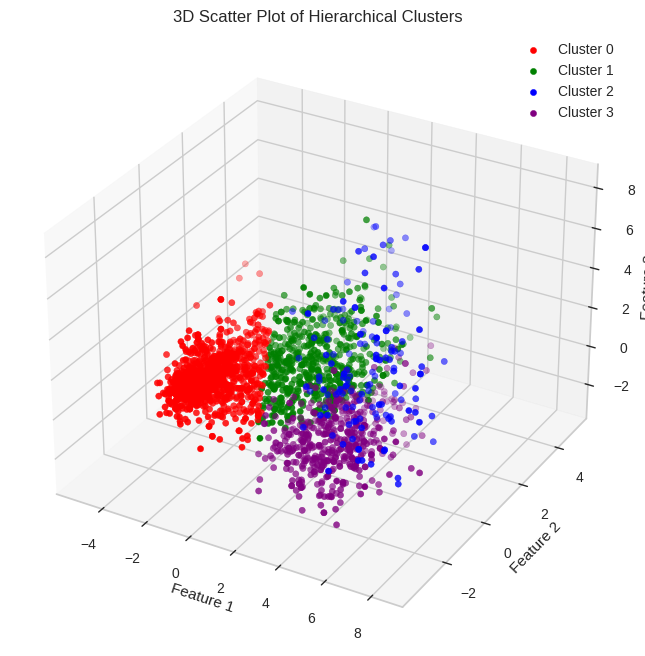

In [109]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'purple']
for cluster in range(4):
    cluster_data = final_df_km[final_df_km['cluster'] == cluster]
    # Replace 'feature1', 'feature2', 'feature3' with actual column names from your DataFrame
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'],
               c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Hierarchical Clusters')
ax.legend()
plt.show()

COMPARING CLUSTERING RESULTS BETWEEN KMEANS AND HIERARCHIAL CLUSTERING


In [110]:
from sklearn.metrics import silhouette_score
silhouette_kmeans = silhouette_score(final_df_km, final_df_km["cluster"])
silhouette_hierarchical = silhouette_score(final_df, final_df["cluster"])
print("Silhouette Score (Hierarchical):", silhouette_hierarchical)
print("Silhouette Score (K-means):", silhouette_kmeans)

Silhouette Score (Hierarchical): 0.3488089976479615
Silhouette Score (K-means): 0.3571249691080854
